In [1]:
# 필요한 라이브러리 임포트
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
from tensorflow.keras.layers import Dense
import os

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# 클래스 수와 모델 정의
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)
x = base_model.output
preds = Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [5]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

In [8]:
# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [9]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [10]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 159s 202ms/step - loss: 2.2489 - accuracy: 0.4385 - val_loss: 3.3442 - val_accuracy: 0.2115
Epoch 2/2
750/750 [==============================] - 152s 202ms/step - loss: 0.6338 - accuracy: 0.8373 - val_loss: 1.2707 - val_accuracy: 0.6382


In [11]:
# 모델 저장 경로 설정 및 모델 저장
cam_model_path = '/aiffel/class_activation_map/cam_model1.h5'
os.makedirs(os.path.dirname(cam_model_path), exist_ok=True)
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
# 데이터 전처리 함수
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
# 샘플 데이터 가져오기
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [15]:
# 모델 로드
cam_model = tf.keras.models.load_model(cam_model_path)

In [16]:
# CAM 생성 함수
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    class_weights = model.layers[-1].get_weights()[0]
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

In [17]:
# 이미지 겹치기 함수
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

In [18]:
# Grad-CAM 생성 함수
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

In [19]:
# 바운딩 박스 및 IoU 계산 함수
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [21]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),
        rect[:,0].min()/float(image.shape[1]),
        rect[:,1].max()/float(image.shape[0]),
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

In [22]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [24]:
# 샘플 데이터를 가져와서 CAM, Grad-CAM, IoU 계산
item = get_one(ds_train)  # 샘플 데이터 가져오기
cam_image = generate_cam(cam_model, item)  # CAM 이미지 생성
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

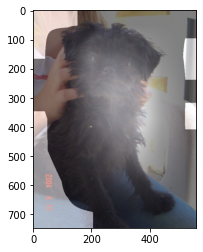

In [25]:
# 원본 이미지와 CAM 이미지 겹치기
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [26]:
# 샘플 데이터 가져오기
item = get_one(ds_train)

In [27]:
# 실제 바운딩 박스 정보 추출
gt_bbox = item['objects']['bbox'][0]  # 첫 번째 객체의 바운딩 박스 정보
print( gt_bbox)

[0.00900901 0.         0.996997   0.926     ]


In [28]:
# 예측된 바운딩 박스 계산
rect = get_bbox(cam_image)
print(rect)

[[ 75  55]
 [502  55]
 [502 684]
 [ 75 684]]


In [29]:
pred_bbox = rect_to_minmax(rect, item['image'])
print("바운딩 박스:", pred_bbox)

바운딩 박스: [0.16516516516516516, 0.15, 2.054054054054054, 1.004]


In [30]:
# IoU 계산
iou = get_iou(gt_bbox, pred_bbox)
print("IoU:", iou)

IoU: 0.3428983455979124


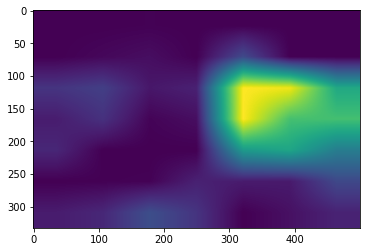

In [31]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

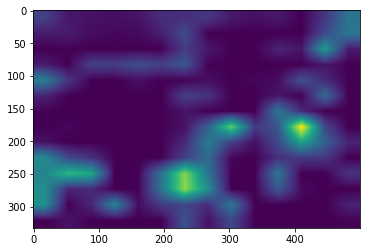

In [32]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

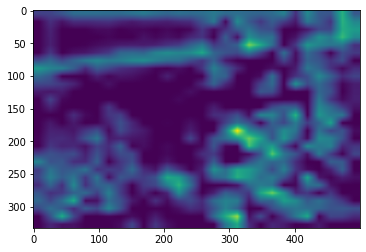

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

11


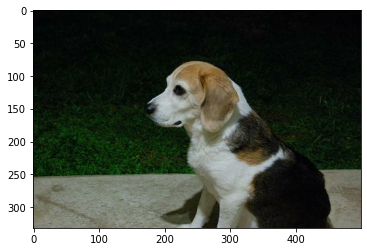

In [34]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

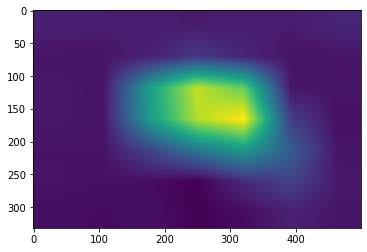

In [35]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

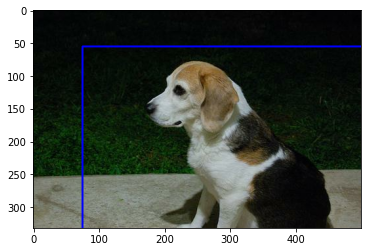

In [36]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

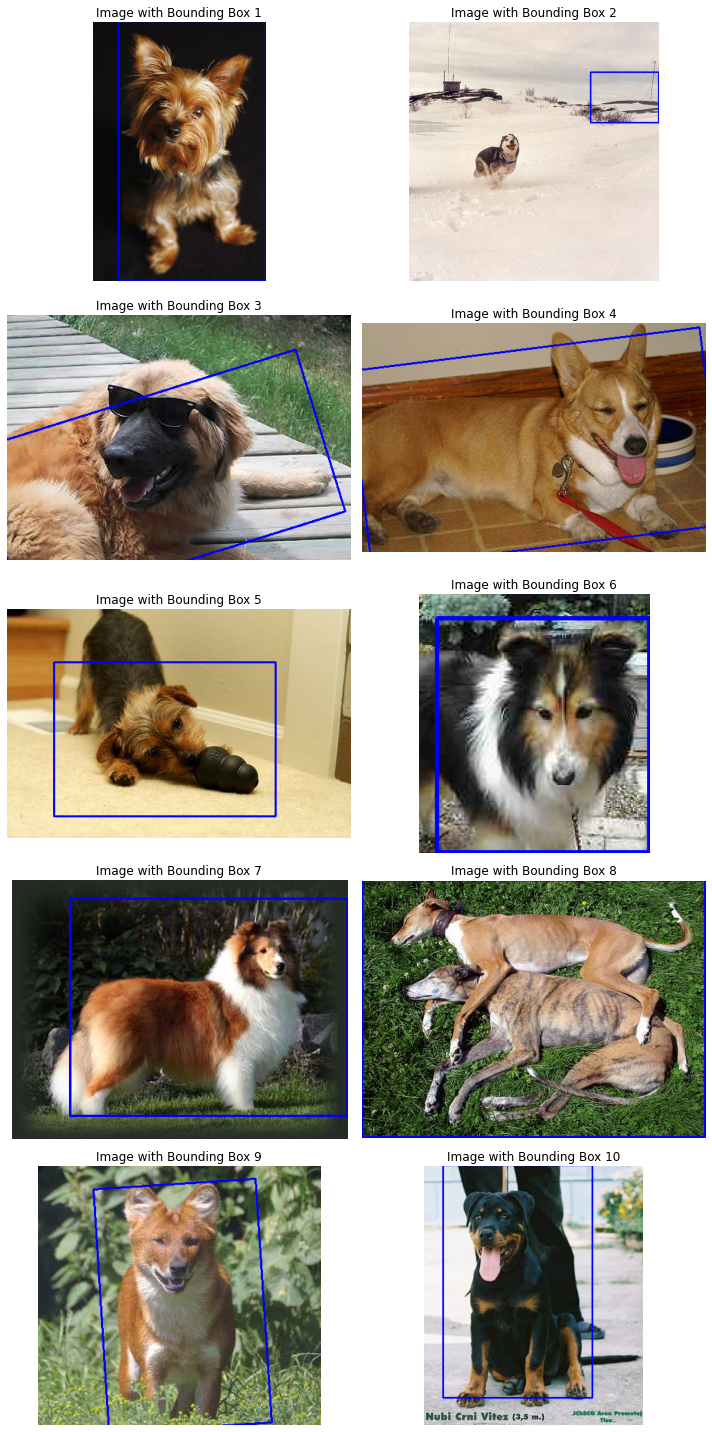

In [41]:
import hashlib

# 이미지 인덱스를 추적하기 위한 집합
selected_indices = set()

fig, axes = plt.subplots(5, 2, figsize=(10, 20))

i = 0  # 이미지 카운트
while i < 10:
    # 샘플 데이터 가져오기
    item = get_one(ds_train)
    
    # 이미지 데이터를 식별자로 사용하기 위해 해시값을 생성합니다.
    # 실제 사용 시에는 데이터셋에 따라 적절한 식별자를 사용해야 합니다.
    image_data = item['image'].tobytes()
    image_id = hashlib.md5(image_data).hexdigest()
    
    # 이미 선택된 이미지인지 확인
    if image_id in selected_indices:
        continue  # 이미 선택된 이미지면 다음 샘플로 넘어갑니다.
    else:
        selected_indices.add(image_id)  # 새 이미지면 집합에 추가합니다.
    
    # CAM 이미지 생성
    cam_image = generate_cam(cam_model, item)
    
    # 바운딩 박스 계산
    rect = get_bbox(cam_image)
    if rect is None:
        continue  # 윤곽선을 찾지 못한 경우, 다음 샘플로 넘어갑니다.
    
    # 원본 이미지 복사 및 바운딩 박스 그리기
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)  # 빨간색으로 바운딩 박스 그리기
    
    # 서브플롯에 이미지 그리기
    ax = axes[i//2, i%2]  # 행 인덱스: i//2, 열 인덱스: i%2
    ax.imshow(image)
    ax.set_title(f"Image with Bounding Box {i+1}")
    ax.axis('off')  # 축 레이블 제거

    i += 1  # 이미지 카운트 증가

plt.tight_layout()
plt.show()

### 회고
바운딩 박스와 이미지를 합친 시각화가 의아한 부분도 많아서 내가 제대로 한건지 의심이 간다.  
처음 시도해보는 iou계산을 하는 부분이 굉장히 어려웠다.  
시간내로 해보고싶은 시도를 전부 해보지는 못했지만 퀘스트 제출후에 다양한 시도를 해보고싶어진다 :)